# Computing different metrics to evaluate topic models

In [1]:
import nlp
import json

import pandas as pd
import seaborn as sns
    
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

### Load and clean data

In [2]:
data = nlp.load_file('../data/lee.txt')
docs = nlp.preprocess(data)
len(data), data[0], docs[0]

(300,
 'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are availabl

### Load computed models

In [3]:
alphas = [0.01, 0.1, 1, 10]
betas = [0.01, 0.1, 1, 10]
num_topics = [5, 10, 15, 20]
models = []

for a in alphas:
    for b in betas:
        for k in num_topics:
            name = '../data/models/lee/{}-{}-{}'.format(a, b, k)
            models.append({ 'alpha': a, 'beta': b, 'num_topics': k, 'lda': LdaModel.load(name) })

### Compute coherence metrics

In [7]:
def add_metrics(model, measure_names, docs):
    'Compute each measure and add it to the given model.'
    for m in measure_names:
        cm = CoherenceModel(model=model['lda'], texts=docs, coherence=m)
        model[m] = cm.get_coherence()

This could take some time to compute 5 x 4 x 4 x 4 = 384 metrics.

In [8]:
measure_names = ['u_mass', 'c_v', 'c_uci', 'c_npmi', 'c_w2v']
for model in models:
    add_metrics(model, measure_names, docs)    

### Add other metrics

In [11]:
def add_other_metrics(models, corpus):
    # Perplexity
    for model in models:
        model['perplexity'] = model['lda'].log_perplexity(corpus)

In [12]:
corpus, dictionary = nlp.build_corpus_dictionary(docs, min_count=10)
add_other_metrics(models, corpus)

### Look at correlation between the metrics

In [18]:
df = pd.DataFrame(models)
df.head()

,alpha,beta,c_npmi,c_uci,c_v,c_w2v,num_topics,perplexity,u_mass
0,0.01,0.01,-0.003759,-1.836443,0.449097,0.998194,5,-6.246609,-2.393090
1,0.01,0.01,-0.037455,-2.854046,0.470005,0.998829,10,-6.302226,-2.233028
2,0.01,0.01,-0.059600,-3.329506,0.433467,0.998800,15,-6.363658,-2.439774
3,0.01,0.01,-0.075871,-3.677816,0.412369,0.998757,20,-6.402373,-2.509307
4,0.01,0.10,-0.008113,-2.012630,0.449335,0.998223,5,-6.038808,-2.413199


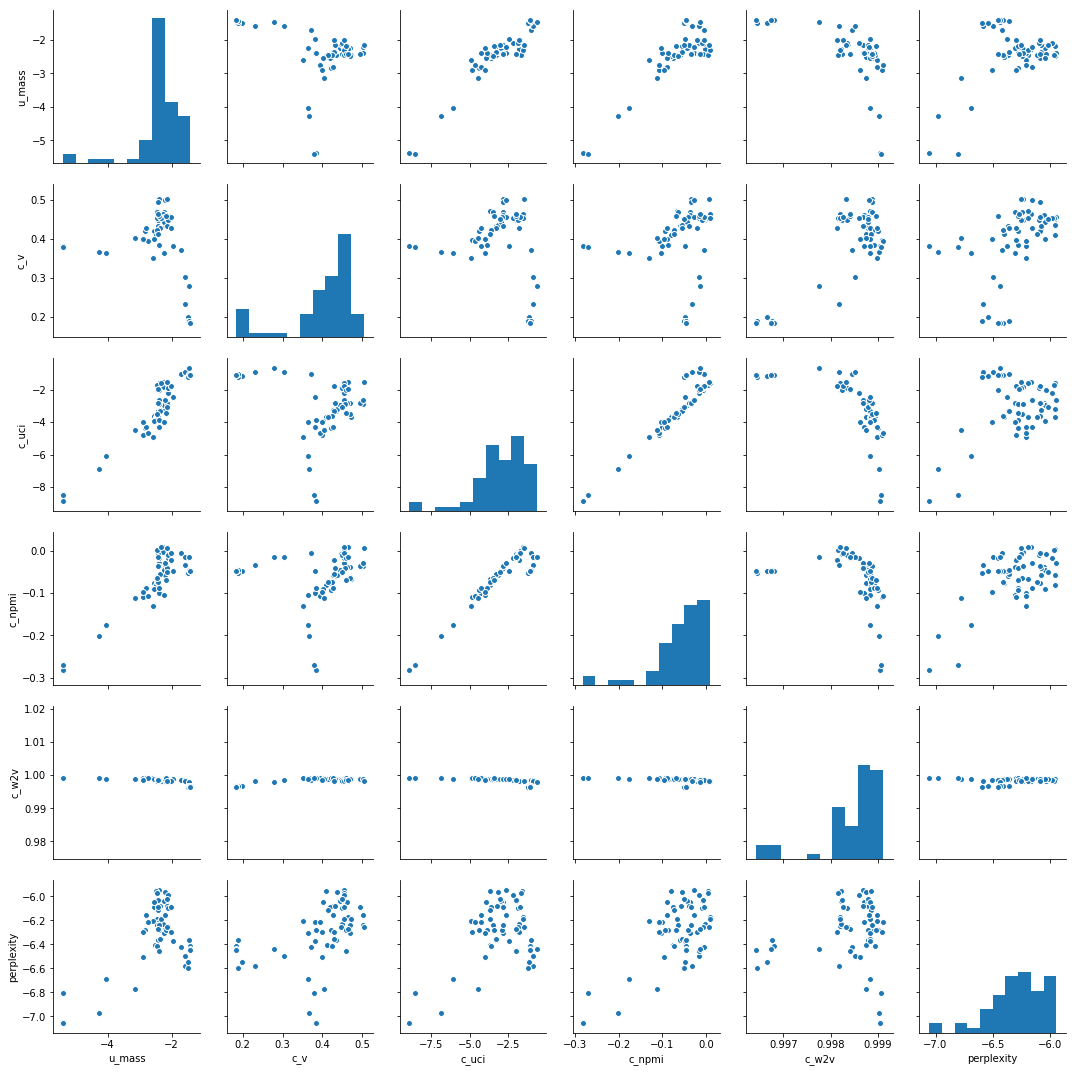

In [14]:
metrics = measure_names + ['perplexity']
sns.pairplot(df[metrics])

In [15]:
df[metrics].corr()

,u_mass,c_v,c_uci,c_npmi,c_w2v,perplexity
u_mass,1.000000,-0.287806,0.912185,0.818642,-0.562415,0.436741
c_v,-0.287806,1.000000,-0.194675,0.173627,0.728527,0.482732
c_uci,0.912185,-0.194675,1.000000,0.927210,-0.636553,0.394107
c_npmi,0.818642,0.173627,0.927210,1.000000,-0.358857,0.610780
c_w2v,-0.562415,0.728527,-0.636553,-0.358857,1.000000,0.138437
perplexity,0.436741,0.482732,0.394107,0.610780,0.138437,1.000000


### Exports metrics

In [24]:
for model in models:
    model.pop('lda', None)
    
with open('../data/lee-metrics.json', 'w') as f:
    json.dump(models, f)

It seems that u_mass, c_uci and c_npmi correlate well. Let's focus on those metrics only.

In [40]:
focus_measures = ['u_mass', 'c_uci', 'c_npmi']

### Look at metrics with different parameter groupings

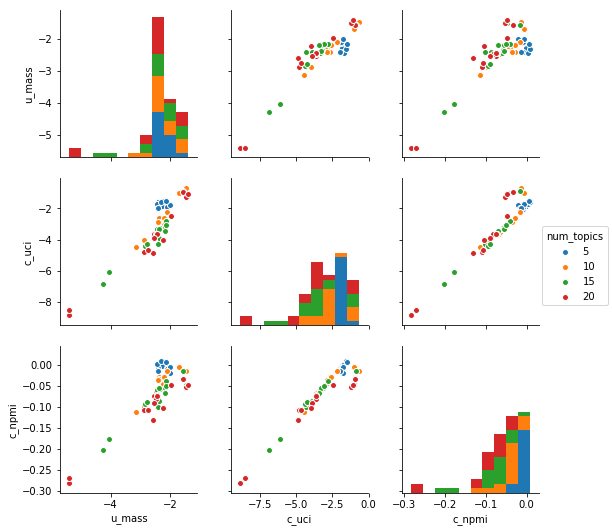

In [43]:
sns.pairplot(df, vars=focus_measures, hue='num_topics')

In [33]:
rank_df = df[focus_measures].rank()
rank_df.head()

,u_mass,c_uci,c_npmi
0,32.0,46.0,58.0
1,41.0,32.0,40.0
2,20.0,24.0,24.0
3,14.0,16.0,17.0
4,24.0,40.5,54.0


In [35]:
rank_df.corr()

,u_mass,c_uci,c_npmi
u_mass,1.000000,0.820094,0.566836
c_uci,0.820094,1.000000,0.842938
c_npmi,0.566836,0.842938,1.000000


In [37]:
df[measure_names].rank().corr()

,u_mass,c_v,c_uci,c_npmi,c_w2v
u_mass,1.000000,-0.102159,0.820094,0.566836,-0.652365
c_v,-0.102159,1.000000,0.040365,0.480465,0.027542
c_uci,0.820094,0.040365,1.000000,0.842938,-0.865434
c_npmi,0.566836,0.480465,0.842938,1.000000,-0.722925
c_w2v,-0.652365,0.027542,-0.865434,-0.722925,1.000000


In [44]:
df[measure_names].corr()

,u_mass,c_v,c_uci,c_npmi,c_w2v
u_mass,1.000000,-0.287806,0.912185,0.818642,-0.559131
c_v,-0.287806,1.000000,-0.194675,0.173627,0.694179
c_uci,0.912185,-0.194675,1.000000,0.927210,-0.651474
c_npmi,0.818642,0.173627,0.927210,1.000000,-0.385126
c_w2v,-0.559131,0.694179,-0.651474,-0.385126,1.000000


---

In [19]:
%load_ext autoreload
%autoreload 2